In [2]:
import numpy as np
import pandas as pd
from nilearn import masking, image
from scipy.stats import ttest_1samp, pearsonr,ttest_ind,ttest_rel
from scipy import stats
import statsmodels.api as sm
from misc.cohensd import cohensd,cohens_d_onesample
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_style('white')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 15})

def p2sign(p):
    if  p<=0.001:
        sign='***'
    elif p<=0.01:
        sign='**'
    elif p<=0.05:
        sign='*'
    else:
        sign='n.s.'
    return sign

## 2D vs 1D

In [5]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
participants_data = participants_data.query("(game1_fmri>=0.5)")
subjects_id = participants_data['Participant_ID'].to_list()

# set cmp template
eucd_cmap = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/distance_spct/Setall/6fold/{}/cmap/distance_cmap.nii.gz'
ap_cmap = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/ap_distance_spct/Setall/6fold/{}/cmap/ap_cmap.nii.gz'
dp_cmap = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/dp_distance_spct/Setall/6fold/{}/cmap/dp_cmap.nii.gz'

# set subjects cmap path
subs_eucd = [eucd_cmap.format(sub) for sub in subjects_id]
subs_ap = [ap_cmap.format(sub) for sub in subjects_id]
subs_dp = [dp_cmap.format(sub) for sub in subjects_id]

# set roi
#dmpfc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/dmPFC/DMN_and_EMO_or_SOC__dmPFC_MNINL.nii.gz')
#vmpfc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/vmPFC_bin.nii.gz')
#dmpfc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/dmPFC/dmPFC_closed_dilated_resampled.nii.gz')
#mpfc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/Park_Grid_ROI/mPFC_GP_roi.nii')
#mpfc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/Park_Grid_ROI/mPFC_GP_roi.nii')
mpfc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_MNI152NL_new.nii.gz')

data = pd.DataFrame()
for effect in ['eucd','ap','dp','mean_1D']:
        if effect != 'mean_1D':
            subs_cmap = eval(f'subs_{effect}')
            act = np.mean(masking.apply_mask(subs_cmap, mpfc), axis=1)
        # elif effect != 'm2value':
        #     subs_cmap = eval(f'subs_{effect}1')
        #     act1 = np.mean(masking.apply_mask(subs_cmap, dmpfc), axis=1)
        #     subs_cmap = eval(f'subs_{effect}2')
        #     act2 = np.mean(masking.apply_mask(subs_cmap, dmpfc), axis=1)
        #     act = np.mean([act1,act2],axis=0)
        elif effect == 'mean_1D':
            # calculate mean 1D activity for each subject from dp and ap distance
            act = (data.query("(effect=='ap')")['act'] + data.query("(effect=='dp')")['act'])/2
        data = pd.concat([data,pd.DataFrame({'sub': subjects_id, 'act': act, 'effect': effect})],axis=0)

eucd: t= 4.8893 p= 0.0 ***
mean_1D: t= 6.5054 p= 0.0 ***
2D vs 1D: t= 3.3653 p= 0.0012 ** cohen's d= 0.315
2D vs AP: t= 2.2422 p= 0.0279 *
2D vs DP: t= 2.949 p= 0.0043 **
AP vs DP: t= -0.0728 p= 0.9422 n.s.


/tmp/ipykernel_201246/3972675647.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x="effect", y="act", data=data_vis, kind="bar", errorbar='se', height=7, aspect=0.4,palette=reds,alpha=1,width=0.7)


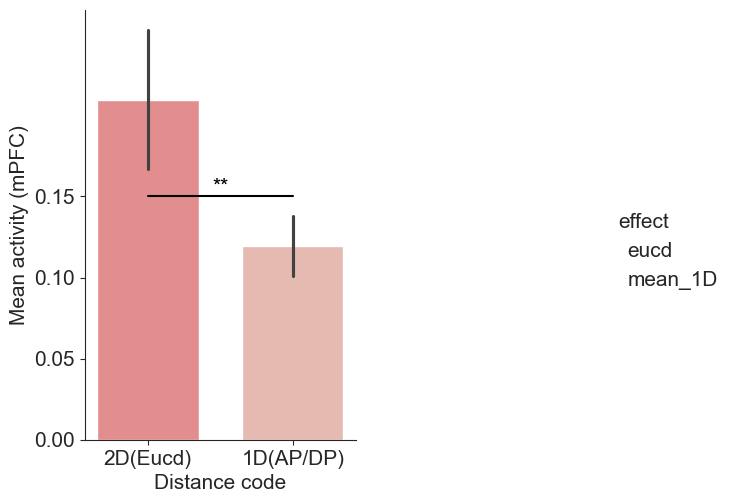

In [6]:
# Define effects
effects = ['eucd','mean_1D']

# Calculate single sample t-tests and print results`
for effect in effects:
    t, p = ttest_1samp(data.query(f"(effect=='{effect}')")['act'], 0,alternative='greater')
    print(f"{effect}:", 't=', round(t,4), 'p=', round(p,4),p2sign(p))

# Calculate the paired sample t-tests
t1, p1 = ttest_rel(data.query("(effect=='eucd')")['act'], data.query("(effect=='mean_1D')")['act'])
cd = cohensd(data.query("(effect=='eucd')")['act'],data.query("(effect=='mean_1D')")['act'])
# Calculate the paired sample t-tests
t2, p2 = ttest_rel(data.query("(effect=='eucd')")['act'], data.query("(effect=='ap')")['act'])
t3, p3 = ttest_rel(data.query("(effect=='eucd')")['act'], data.query("(effect=='dp')")['act'])
t4,p4 = ttest_rel(data.query("(effect=='ap')")['act'], data.query("(effect=='dp')")['act'])

# Print the results
print('2D vs 1D:','t=', round(t1,4), 'p=', round(p1,4), p2sign(p1), "cohen's d=",round(cd,4))
print('2D vs AP:','t=', round(t2,4), 'p=', round(p2,4), p2sign(p2))
print('2D vs DP:','t=', round(t3,4), 'p=', round(p3,4), p2sign(p3))
print('AP vs DP:','t=', round(t4,4), 'p=', round(p4,4), p2sign(p4))

# Create the bar plot using seaborn
#reds = ['#f07167','#f8ad9d','#ffdab9']
reds= ['#F08080','#EDB4A8']# ,'#FFD7D9'
data_vis = data.query('effect in ["eucd","mean_1D"]')
g = sns.catplot(x="effect", y="act", data=data_vis, kind="bar", errorbar='se', height=7, aspect=0.4,palette=reds,alpha=1,width=0.7)
#g = sns.catplot(x="effect", y="act", data=data_vis, kind="violin", errorbar='se', height=7, aspect=0.7,palette=reds,width=0.2)
# Add scatter plots for each bar
#sns.stripplot(x="effect", y="act", data=data_vis, jitter=True, dodge=True, palette=reds, alpha=0.5)
g.fig.set_size_inches(10,5)

# set y title
g.ax.set_xlabel('Distance code')
g.ax.set_ylabel('Mean activity (mPFC)')

# Set y ticks
plt.xticks([0,1],['2D(Eucd)','1D(AP/DP)'])
plt.yticks([0,0.05, 0.1, 0.15])

# Add tick lines to the bottom and left spines
g.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
g.tick_params(axis='y', which='both', left=True, right=False, direction='out')

# Add significance indicators
x1, x2 = 0, 1  # columns '2D' and '1D-AP' (first pair)
y, h, col = 0.15, 0, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, p2sign(p1), ha='center', va='bottom', color=col)

#savepath = r'/mnt/workdir/DCM/Result/paper/figure3/VMPFC/Distance_beta_ROI-VMPFC.pdf'
#plt.savefig(savepath,bbox_inches='tight',pad_inches=0,dpi=300,transparent=True)
# Show the plot
plt.show()

# Value vs Attribute

In [21]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
participants_data = participants_data.query("(game1_fmri>=0.5)")
participants_data = participants_data.query("(game1_acc>0.8)")
subjects_id = participants_data['Participant_ID'].to_list()

# set cmp template
value_cmap = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/value_spct/Setall/6fold/{}/cmap/value_cmap.nii.gz'
pure_value_cmap = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/pure_value_spct/Setall/6fold/{}/cmap/value_cmap.nii.gz'
#m2vlaue = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn_test/game1/value_spct/Setall/6fold/{}/cmap/M2_corrxvalue_cmap.nii.gz'
# deucd_cmap = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn_test/game1/distance_spct/Setall/6fold/{}/zmap/decision_corrxdistance_zmap.nii.gz'

# set subjects cmap path
subs_value = [value_cmap.format(sub) for sub in subjects_id]
subs_pure_value = [pure_value_cmap.format(sub) for sub in subjects_id]
#subs_m2value  = [m2vlaue.format(sub) for sub in subjects_id]
# subs_deucd = [deucd_cmap.format(sub) for sub in subjects_id]

# set roi
#vmpfc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/vmPFC_bin.nii.gz')
mpfc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_MNI152NL_new.nii.gz')
data = pd.DataFrame()
for effect in ['value','pure_value']:
    subs_cmap = eval(f'subs_{effect}')
    act = np.mean(masking.apply_mask(subs_cmap,mpfc), axis=1)
    data = pd.concat([data,pd.DataFrame({'sub': subjects_id, 'act': act, 'effect': effect})], axis=0)

value: t= 4.5645 p= 0.0 ***
pure_value: t= -1.7148 p= 0.0906 n.s.
value vs pure_value: t= 4.641 p= 0.0 *** cohen's d= 0.7827


/tmp/ipykernel_201246/1557682563.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x="effect", y="act", data=data, kind="bar", errorbar='se', height=7, aspect=1,palette=blues[:3],alpha=1,width=0.6)


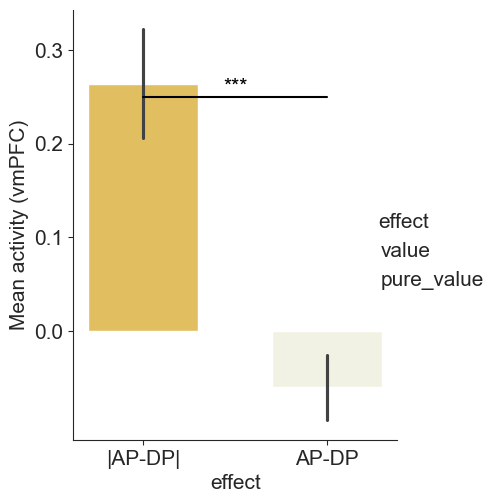

In [22]:
# Define effects
effects = ['value','pure_value']

# Calculate single sample t-tests and print results
for effect in effects:
    t, p = ttest_1samp(data.query(f"(effect=='{effect}')")['act'], 0)
    print(f"{effect}:", 't=', round(t,4), 'p=', round(p,4),p2sign(p))
#
# # Calculate the paired sample t-tests
t1, p1 = ttest_rel(data.query(f"(effect=='value')")['act'], data.query(f"(effect=='pure_value')")['act'])
cd = cohensd(data.query(f"(effect=='value')")['act'],data.query(f"(effect=='pure_value')")['act'])
#
# # Print the results
print('value vs pure_value:', 't=', round(t1,4), 'p=', round(p1,4),p2sign(p1), "cohen's d=",round(cd,4))
#print('value vs m2_value:', 't=', round(t2,4), 'p=', round(p2,4),p2sign(p2))
# print('value vs dp:', 't=', round(t3,4), 'p=', round(p3,4),p2sign(p3))
# print('dp vs ap:', 't=', round(t4,4), 'p=', round(p4,4),p2sign(p4))

muted_palette = sns.color_palette("bright")
#new_palette = [muted_palette[0],muted_palette[3],muted_palette[2]]
blues = ['#F6C94B','#F4F4E2']
#'#FFEBCD'
g = sns.catplot(x="effect", y="act", data=data, kind="bar", errorbar='se', height=7, aspect=1,palette=blues[:3],alpha=1,width=0.6)
g.fig.set_size_inches(5,5)
plt.xticks([0,1],['|AP-DP|','AP-DP'])
plt.yticks([0, 0.1, 0.2,0.3])

# set y title
#g.ax.set_xlabel('Value effect')
g.ax.set_ylabel('Mean activity (vmPFC)')
# Add tick lines to the bottom and left spines
g.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
g.tick_params(axis='y', which='both', left=True, right=False, direction='out')

# Add significance indicators
x1, x2 = 0, 1  # columns '2D' and '1D-AP' (first pair)
y, h, col = 0.25, 0, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, p2sign(p1), ha='center', va='bottom', color=col)

#savepath = r'/mnt/workdir/DCM/Result/paper/sf/sf4/valueVSpurevalue.pdf'
#plt.savefig(savepath,bbox_inches='tight',pad_inches=0,dpi=300,transparent=True)
#Show the plot
plt.show()

## Mean effect

In [ ]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('(game1_fmri>=0.5)and(game1_acc>0.8)')  # look out
subjects = data['Participant_ID'].to_list()
num = len(subjects)
# set camp
cmap_template = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/distance_spct/Setall/6fold/{}/zmap/M2_corrxdistance_zmap.nii.gz'
sub_cmap_paths = [cmap_template.format(sub_id) for sub_id in subjects]

# set roi
roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/lHC_MNI152NL.nii.gz')
roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/rHC_MNI152NL.nii.gz')
hc = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
#ec = image.load_img(r'/mnt/data/DCM/result_backup/2023.4.17/game1/hexagon_spct/EC_thr3.1.nii.gz')
ec = image.binarize_img(ec,5)

# extract mean activity of ROI for each subjects
subs_hc_mact = np.mean(masking.apply_mask(sub_cmap_paths, hc), axis=1)
subs_ec_mact = np.mean(masking.apply_mask(sub_cmap_paths, ec), axis=1)

# mean
t_statistic, p_value = ttest_1samp(subs_hc_mact, 0)
print("HC's t:", t_statistic)
print("HC's p:", p_value)

t_statistic, p_value = ttest_1samp(subs_ec_mact, 0)
print("EC's t:", t_statistic)
print("EC's p:", p_value)

In [ ]:
distance_bar = pd.DataFrame({'HC':subs_hc_mact,'EC':subs_ec_mact})
# adjust data format to plot
distance_bar = pd.melt(distance_bar,  value_vars=['HC', 'EC'], var_name='ROI', value_name='Distance effect (Z)')
# Initialize a Figure and Axes
fig, ax = plt.subplots(figsize=(5,7))
sns.barplot(
    data=distance_bar,
    x="ROI", y="Distance effect (Z)",
    errorbar="se", capsize=.15, errcolor="0.5",
    linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0),
    ax=ax
)
# Loop over the bars, and add a '*' label
for i, bar in enumerate(ax.containers[0]):
    height = bar.get_height()
    if i == 0:
        ax.text(bar.get_x() + bar.get_width() / 2, 0.36, "***", ha='center', va='bottom', fontsize=18,fontweight='bold')
    elif i == 1:
        ax.text(bar.get_x() + bar.get_width() / 2, 0.36, "*", ha='center', va='bottom', fontsize=18,fontweight='bold')

ax.set_xlabel('ROI', fontsize=15)
ax.set_ylabel('Distance effect (Z)', fontsize=15)
# Adjust the tick parameters
# Add tick lines to the bottom and left spines
ax.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
ax.tick_params(axis='y', which='both', left=True, right=False, direction='out')
# remove the box lines of the axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# Set custom ticks for the x-axis and y-axis
plt.yticks([0,0.10,0.20,0.30],size=12)
plt.xticks(size=14)
#plt.savefig(r'/mnt/workdir/DCM/Result/paper/supplementary figure2/distance_roi_hc&ec.pdf',bbox_inches='tight',pad_inches=0,dpi=300,transparent=True)
plt.show()

## Align vs Misalign

In [4]:
# plot align vs misalign

# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('game2_fmri>=0.5')
#data = data.query('game1_acc>0.8')
subjects = data['Participant_ID'].to_list()
num = len(subjects)

# set camp
algin_template = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game2/hexModdistance_spct/Setall/6fold/{}/cmap/alignxdistance_cmap.nii.gz'
misalgin_template = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game2/hexModdistance_spct/Setall/6fold/{}/cmap/misalignxdistance_cmap.nii.gz'

sub_algin_cmaps = [algin_template.format(sub_id) for sub_id in subjects]
sub_misalgin_cmaps = [misalgin_template.format(sub_id) for sub_id in subjects]

# load mask
mpfc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_MNI152NL_new.nii.gz')
#mpfc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/mPFC/BiMPFC_NeuroSynth_MNINL_c2o3.nii.gz')
# ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
# ec = image.binarize_img(ec,5)
#ec = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/hexagon_spct/EC_thr3.1.nii.gz'
#ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/func/alignPhi_even_zmap_thr2.3.nii.gz')

# load data
subs_align_mact = np.mean(masking.apply_mask(sub_algin_cmaps, mpfc), axis=1)
subs_misalign_mact = np.mean(masking.apply_mask(sub_misalgin_cmaps, mpfc), axis=1)

subs_mact = np.concatenate((subs_align_mact, subs_misalign_mact),axis=0)
hexModdistance_data = pd.DataFrame({'Activity':subs_mact,'Trials':num*['Aligned']+num*['Misaligned']})

In [24]:
# mean
t_statistic, p_value = ttest_1samp(subs_align_mact, 0)
print("Align's t:", t_statistic)
print("Align's p:", p_value)

t_statistic, p_value = ttest_1samp(subs_misalign_mact, 0)
print("Misalign's t:", t_statistic)
print("Misalign's p:", p_value)

t_statistic, p_value = ttest_rel(subs_align_mact, subs_misalign_mact, alternative='greater')
cd = cohensd(subs_align_mact,subs_misalign_mact)
print("Align vs Misalign's t:", t_statistic)
print("Align vs Misalign's p:", p_value)
print("Cohen's d:",cd)

Align's t: 4.424938812454434
Align's p: 3.264922297667887e-05
Misalign's t: 4.112259173394832
Misalign's p: 0.00010039188039003707
Align vs Misalign's t: 2.724483603381523
Align vs Misalign's p: 0.004015752864536402
Cohen's d: 0.2221266267705562


/tmp/ipykernel_201246/604782595.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x="Trials", y="Activity", data=hexModdistance_data, kind="bar", errorbar='se', height=7, aspect=0.4,palette=colors,alpha=1,width=0.5)


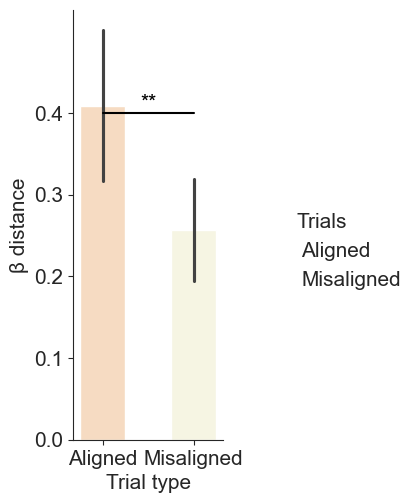

In [16]:
# Create the bar plot using seaborn
#reds = ['#f07167','#f8ad9d','#ffdab9']
colors= ['#FFDAB9','#F9F8E0']#

#colors = sns.color_palette("pastel")[:2][::-1]# '#FFD7D9'
g = sns.catplot(x="Trials", y="Activity", data=hexModdistance_data, kind="bar", errorbar='se', height=7, aspect=0.4,palette=colors,alpha=1,width=0.5)
g.fig.set_size_inches(5,5)

# set y title
g.ax.set_xlabel('Trial type')
g.ax.set_ylabel(u'\u03B2'+' distance')
g.ax.set_yticks([0,0.1,0.2,0.3,0.4])

# Set y ticks
#plt.xticks([0,1],['2D(Eucd)','1D(AP/DP)'])
# plt.yticks([0, 0.1, 0.2, 0.3, 0.4])

# Add tick lines to the bottom and left spines
g.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
g.tick_params(axis='y', which='both', left=True, right=False, direction='out')

# Add significance indicators
x1, x2 = 0, 1  # columns '2D' and '1D-AP' (first pair)
y, h, col = 0.4, 0, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, p2sign(p_value), ha='center', va='bottom', color=col)

#savepath = r'/mnt/workdir/DCM/Result/paper/figure3/VMPFC/HexModDistance_ROI-VMPFC_6fold_alignVSmisalign.pdf'
#plt.savefig(savepath,bbox_inches='tight',pad_inches=0,dpi=300,transparent=True)

# Show the plot
plt.show()

## All mediaiton effect in one plot

In [108]:
# plot all mediaiton effect in one plot

# load mediation results
hexagon_med = pd.read_csv(r'/mnt/workdir/DCM/Result/paper/figure2/Hexagon_RSA_mediation.csv')
distance_med = pd.read_csv(r'/mnt/workdir/DCM/Result/paper/figure3/Park-mPFC/Mediation_distance_Park-mPFC.csv')
hexModdistance_med = pd.read_csv(r'/mnt/workdir/DCM/Result/paper/figure3/Park-mPFC/Mediation_HexModDistance_Park-mPFC.csv')
value_med = pd.read_csv(r'/mnt/workdir/DCM/Result/paper/figure3/Mediation_value_vmPFC.csv')
parallel_med = pd.read_csv(r'/mnt/workdir/DCM/Result/paper/figure3/Park-mPFC/Mediation_hexagon_diistance_parallel.csv')


mediation_results = pd.DataFrame({
    'mediation': ['hexagon', 'distance', 'hexModdistance', 'value', 'parallel_hexagon', 'parallel_distance'],
    'CI_low': [hexagon_med.loc[hexagon_med['path']=='Indirect', 'CI[2.5%]'].values[0],
               distance_med.loc[distance_med['path']=='Indirect', 'CI[2.5%]'].values[0],
               hexModdistance_med.loc[hexModdistance_med['path']=='Indirect', 'CI[2.5%]'].values[0],
               value_med.loc[value_med['path']=='Indirect', 'CI[2.5%]'].values[0],
               parallel_med.loc[parallel_med['path']=='Indirect hexagon', 'CI[2.5%]'].values[0],
               parallel_med.loc[parallel_med['path']=='Indirect distance', 'CI[2.5%]'].values[0]],
    'CI_high': [hexagon_med.loc[hexagon_med['path']=='Indirect', 'CI[97.5%]'].values[0],
                distance_med.loc[distance_med['path']=='Indirect', 'CI[97.5%]'].values[0],
                hexModdistance_med.loc[hexModdistance_med['path']=='Indirect', 'CI[97.5%]'].values[0],
                value_med.loc[value_med['path']=='Indirect', 'CI[97.5%]'].values[0],
                parallel_med.loc[parallel_med['path']=='Indirect hexagon', 'CI[97.5%]'].values[0],
                parallel_med.loc[parallel_med['path']=='Indirect distance', 'CI[97.5%]'].values[0]],
    'sig': [hexagon_med.loc[hexagon_med['path']=='Indirect', 'sig'].values[0] == 'Yes',
            distance_med.loc[distance_med['path']=='Indirect', 'sig'].values[0] == 'Yes',
            hexModdistance_med.loc[hexModdistance_med['path']=='Indirect', 'sig'].values[0] == 'Yes',
            value_med.loc[value_med['path']=='Indirect', 'sig'].values[0] == 'Yes',
            parallel_med.loc[parallel_med['path']=='Indirect hexagon', 'sig'].values[0] == 'Yes',
            parallel_med.loc[parallel_med['path']=='Indirect distance', 'sig'].values[0] == 'Yes']
})


fig,ax = plt.subplots(figsize=(6, 8))
sns.set_palette('pastel')

# We use hlines to draw horizontal lines at each y position
plt.hlines(y=mediation_results['mediation'], xmin=mediation_results['CI_low'], xmax=mediation_results['CI_high'],
           colors='b', linewidth=2)

# We use errorbar to add caps at the end of each line
plt.errorbar(x=(mediation_results['CI_low'] + mediation_results['CI_high']) / 2,
             y=mediation_results.index,
             xerr=[mediation_results['CI_high'] - (mediation_results['CI_low'] + mediation_results['CI_high']) / 2,
                   (mediation_results['CI_low'] + mediation_results['CI_high']) / 2 - mediation_results['CI_low']],
             fmt='o',capsize=8,capthick=2,linewidth=2,markersize=9)

# Determine the x position of labels
label_x_position = max(mediation_results['CI_high']) + 0.01  # or set a value according to your data

for i, row in mediation_results.iterrows():
    label = '*' if row['sig'] else ''
    plt.text(label_x_position, i, label, va='center', size=15)

# Modify tick parameters
ax.tick_params(axis='y', which='both', left=True, right=False, direction='out')
ax.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
plt.xlim(-0.025,0.1)

# remove the box lines of the axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.ylabel('Neural represenation')
plt.xlabel('Confidence Interval [2.5% - 97.5%] for indirect effect ')
plt.axvline(0, color='black', linestyle='--',alpha=0.8)

# Reverse y-axis
#ax.invert_yaxis()
# Rotate y labels
# plt.yticks(r#otation=45)

plt.tight_layout()
plt.savefig(r'/mnt/workdir/DCM/Result/paper/figure3/mediation_all.pdf',bbox_inches='tight',pad_inches=0,dpi=300,transparent=True)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/workdir/DCM/Result/paper/figure3/Park-mPFC/Mediation_distance_Park-mPFC.csv'

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.patches import Rectangle
from scipy import stats

# load mediation results
hexagon_bsample = np.load(r'/mnt/workdir/DCM/Result/paper/figure2/Indirect_beta_sample_hexagon.npy')
distance_bsample  = np.load(r'/mnt/workdir/DCM/Result/paper/figure3/mediation/Indirect_beta_sample_Distance_mPFC.npy')
hc_bsample  = np.load(r'/mnt/workdir/DCM/Result/paper/figure3/mediation/Indirect_beta_sample_distance_HC.npy')
parallel_bsample = np.load(r'/mnt/workdir/DCM/Result/paper/figure3/mediation/Indirect_beta_sample_Parallel.npy')
parallel_hexagon_bsample = parallel_bsample[:,0]
parallel_distance_bsample = parallel_bsample[:,1]

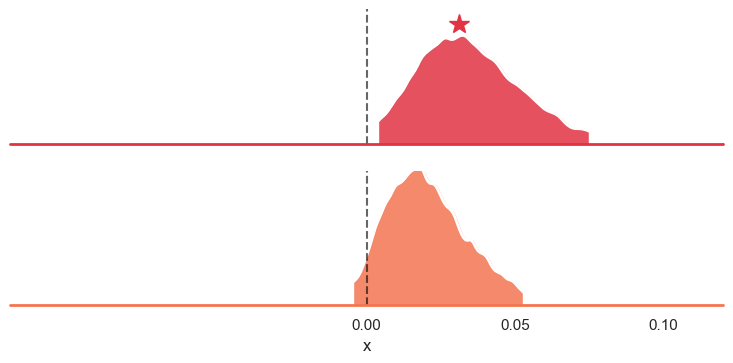

In [14]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# List of bsample data
#bsample_data = [hexagon_bsample, distance_bsample]
bsample_data = [parallel_hexagon_bsample, parallel_distance_bsample]
#bsample_data == [parallel_hexagon_bsample,parallel_distance_bsample]
#bsample_data = [hexagon_bsample,distance_bsample,hexModdistance_bsample]
# List of bsample labels
#bsample_labels = ['Grid-like code (EC)', 'Distance code (mPFC)']
bsample_labels = ['Grid-like code (EC)','Distance code (mPFC)']
#bsample_labels = ['Hexagon(EC)','Distance(mPFC)','Distance(align-misalign)']
# Empty dataframe for concatenation
df = pd.DataFrame()

# Concatenating all bsample data into one DataFrame
for i in range(len(bsample_data)):
    temp = pd.DataFrame(bsample_data[i], columns=['x'])
    temp['g'] = bsample_labels[i]
    df = pd.concat([df, temp])

# Create the color palette
#pal = sns.cubehelix_palette(len(bsample_data), rot=0.5, light=.72)
pal = sns.color_palette("rocket_r", 6)[1:3]
pal = pal[::-1]
#pal = pal[:2]+pal
# 创建一个新的列表，用于存储调整饱和度后的颜色
new_palette = []

# 通过遍历原始的色彩列表，调整每种颜色的饱和度
for color in pal:
    new_color = sns.desaturate(color,1)
    new_palette.append(new_color)

# Create the FacetGrid object
g = sns.FacetGrid(df, row="g", hue="g", aspect=4, height=2, palette=new_palette)

# Draw the densities
g.map(sns.kdeplot, "x", bw_adjust=.5, clip_on=True, fill=True, alpha=0.85, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=True, color="w", lw=2, bw_adjust=.5, alpha=1)

# Draw the vertical line at zero for all plots
g.map(plt.axvline, x=0, color='black', linestyle='--',alpha=0.6)

# Draw the vertical line for lower boundary of distribution for all plots
ci = 0.95
for i, data in enumerate(bsample_data):
    lower = np.percentile(data, (1 - ci) / 2 * 100)
    upper = np.percentile(data, (1 + ci) / 2 * 100)
    median = np.median(data)
    # Compute KDE to get y range
    density = stats.gaussian_kde(data)
    xs = np.linspace(np.min(data), np.max(data), 1000)
    ys = density(xs)
    ymax = np.max(ys)# half of the maximum y value
    # Find the index of the maximum value in ys
    max_index = np.argmax(ys)
    # Get the corresponding x-coordinate (xp) from xs
    xp = xs[max_index]
    
    # Add the rectangle to cover areas outside the confidence interval
    rectangle_left = Rectangle((-0.08, 0), lower+0.08, ymax, color='white',alpha=1)
    rectangle_right = Rectangle((upper, 0), 0.12-upper, ymax, color='white',alpha=1)
    g.axes[i][0].add_patch(rectangle_left)
    g.axes[i][0].add_patch(rectangle_right)
    #g.axes[i][0].plot([lower, lower], [0, ymax*0.72], color=pal[i], linestyle='-',alpha=1)
    # If the lower boundary is greater than 0, add a star marker
    if lower > 0:
        star = mlines.Line2D([xp], [ymax*1.13], color=pal[i], marker='*', linestyle='None', markersize=15,zorder=10)
        g.axes[i][0].add_line(star)
    #g.axes[i][0].hlines(0, -0.08, 0.12, colors='red', linestyles='-', lw=2)

g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Add labels
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color=color, ha="left", va="center", transform=ax.transAxes,size=0)

#g.map(label, "x")

# Adjust y-limits
for i, ax in enumerate(g.axes.flatten()):
    data = bsample_data[i]
    density = stats.gaussian_kde(data)
    ys = density(np.linspace(np.min(data), np.max(data), 200))
    ymax = np.max(ys)  # the maximum y value
    ax.set_ylim(0, ymax)

# Set the subplots to overlap and remove axes details that don't play well with overlap
g.figure.subplots_adjust(hspace=0.2)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Set x-axis limits
g.set(xlim=(-0.12, 0.12))
g.set(xticks=[0, 0.05, 0.1])

plt.savefig(r'/mnt/workdir/DCM/Result/paper/figure3/mediation/mediation_parallel_ridge_plot.pdf',bbox_inches='tight',pad_inches=0,dpi=300, transparent=True)
plt.show()